In [1]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 0s (983 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 123629 files and directories currently installed.)
Pre

In [2]:
!pip install PyAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyAudio: filename=PyAudio-0.2.14-cp310-cp310-linux_x86_64.whl size=63859 sha256=660c78f0f0da50fd0a3b188b51a16f753576e1783f27bdc236b0ee4ca62242c1
  Stored in directory: /root/.cache/pip/wheels/d6/21/f4/0b51d41ba79e51b16295cbb096ec49f334792814d545b508c5
Successfully built PyAudio


In [56]:
import enum
import wave
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import pareto


class Signals(enum.Enum):
    SIN = 0,
    TRIANGLE = 1,
    PULSE = 2
    SAWTOOTH = 3,
    WHITE_NOISE = 4


class SoundSignal:
    data = np.array([])
    name = ''

    def __init__(self, a, fr, n, phi):
        self.a = a
        self.fr = fr
        self.n = n
        self.phi = phi

    def generate_sound(self):
        raise NotImplementedError("Subclasses must implement this method")

    def freq_sound(self, modulate):
        raise NotImplementedError("Subclasses must implement this method")

    def to_wav(self):
        max_amplitude = np.iinfo(np.int16).max
        audio_data = (self.data * max_amplitude).astype(np.int16)

        with wave.open(self.name + '.wav', 'w') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(2)
            wav_file.setframerate(2048)
            wav_file.writeframes(audio_data.tobytes())

    def ampl_sound(self, modulate):
        raise NotImplementedError("Subclasses must implement this method")

    def plot_signal(self):
        raise NotImplementedError("Subclasses must implement this method")


class SinSignal(SoundSignal):
    name = 'sin'

    def generate_sound(self):
        n0 = np.arange(self.n, dtype=float)
        self.data = self.a * np.sin(2 * np.pi * self.fr * n0 / 2048 + self.phi)
        return self.data

    def freq_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n) / self.n
        phi = self.phi
        for i in range(0, self.n):
            self.data[i] = np.sin(phi) * self.a
            phi += 2 * np.pi * self.fr * (1 + modulate.data[i]) / 2048


    def ampl_sound(self, modulate):
        modulate.generate_sound()
        self.data = np.arange(self.n) / self.n
        for i in range(0, self.n):
            self.data[i] = self.a * (1 + modulate.data[i]) * np.sin(2 * np.pi * self.fr * i / 2048 + self.phi)

    def plot_signal(self):
        n0 = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n0, self.data, label='Синусоидальный сигнал')
        plt.title('Синусоидальный сигнал')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        plt.show()


class TriangleSignal(SoundSignal):
    name = 'triangle'

    def generate_sound(self):

        n = np.arange(self.n)
        self.data = (2 * self.a / np.pi) * (
                np.abs((2 * np.pi * self.fr * n / 2048 + self.phi + 3 * np.pi / 2) % (2 * np.pi) - np.pi) - (
                np.pi / 2))
        return self.data

    def ampl_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n)
        for i in range(0, self.n):
            self.data[i] = (2 * self.a * (1 + modulate.data[i]) / np.pi) * (
                    np.abs((2 * np.pi * self.fr * i / 2048 + self.phi + 3 * np.pi / 2) % (2 * np.pi) - np.pi) - (
                    np.pi / 2))

    def freq_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n) / self.n
        phi = self.phi
        for i in range(0, self.n):
            self.data[i] = (2 * self.a * (1 + modulate.data[i]) / np.pi) * (
                    np.abs((phi + 3 * np.pi / 2) % (2 * np.pi) - np.pi) - (
                    np.pi / 2))
            phi += 2 * np.pi * self.fr * (1 + modulate.data[i]) / self.n

    def plot_signal(self):
        n = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n, self.data, label='Треугольный сигнал')
        plt.title('Треугольный сигнал')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        plt.show()


class PulseSignal(SoundSignal):
    name = 'pulse'

    def __init__(self, a, fr, n, phi, d=0.5):
        super(PulseSignal, self).__init__(a, fr, n, phi)
        self.d = d

    def generate_sound(self):
        n = np.arange(self.n)
        mod_value = (2 * np.pi * self.fr * n / 2048 + self.phi) % (2 * np.pi)
        self.data = np.where(mod_value / (2 * np.pi) <= self.d, self.a, -self.a)
        return self.data

    def ampl_sound(self, modulate):
        modulate.generate_sound()

        mod_value = np.arange(self.n)
        for i in range(0, self.n):
            mod_value[i] = (1 + modulate.data[i]) * (2 * np.pi * self.fr * i / 2048 + self.phi) % (2 * np.pi)

        self.data = np.where(mod_value / (2 * np.pi) <= self.d, self.a, -self.a)

    def freq_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n) / self.n
        phi = self.phi
        for i in range(0, self.n):
            mod_value = phi % (2 * np.pi)
            phi += 2 * np.pi * self.fr * (1 + modulate.data[i]) / 2048

            self.data[i] = np.where(mod_value / (2 * np.pi) <= self.d, self.a, -self.a)




    def plot_signal(self):
        n = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n, self.data, label='Импульсный сигнал')
        plt.title('Импульсный сигнал')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        plt.show()


class Sawtooth(SoundSignal):
    name = 'sawtooth'

    def generate_sound(self):
        n = np.arange(self.n)
        self.data = (self.a / np.pi) * ((2 * np.pi * self.fr * n / 2048 + self.phi + np.pi) % (2 * np.pi) - np.pi)
        return self.data

    def ampl_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n) / self.n

        for i in range(0, self.n):
            self.data[i] = (self.a * (1 + modulate.data[i]) / np.pi) * ((2 * np.pi * self.fr * i / 2048 + self.phi + np.pi) % (2 * np.pi) - np.pi)

    def freq_sound(self, modulate):
        modulate.generate_sound()

        self.data = np.arange(self.n) / self.n
        phi = self.phi
        for i in range(0, self.n):
            self.data[i] = (self.a / np.pi) * ((phi + np.pi) % (2 * np.pi) - np.pi)
            phi += 2 * np.pi * self.fr * (1 + modulate.data[i])/ 2048


    def plot_signal(self):
        n = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n, self.data, label='Зубчатый сигнал')
        plt.title('Зубчатый сигнал')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.ylim(-self.a * 1.1, self.a * 1.1)
        plt.legend()
        plt.show()


class WhiteNoise(SoundSignal):
    name = 'white_noise'

    def __init__(self, duration=1, sample_rate=2048):
        super().__init__(a=20000, fr=0, n=int(sample_rate * duration), phi=0)
        self.duration = duration


    def generate_sound(self):
        self.data = np.random.uniform(-self.a, self.a, self.n)
        return self.data

    def plot_signal(self):
        n = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n, self.data, label='Белый шум', marker='o', markersize=1)
        plt.title('Белый шум')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.ylim(-1.1, 1.1)
        plt.legend()
        plt.show()


class PolyphonicSignal(SoundSignal):
    def __init__(self, signals, n):
        super().__init__(a=0, fr=0, n=0, phi=0)
        self.signals = signals
        self.n = n
        self.name = 'polyphonic'

    def generate_sound(self):
        self.data = np.zeros(self.n, dtype=float)
        for signal in self.signals:
            self.data += signal.data

        return self.data

    def plot_signal(self):
        n = np.arange(self.n)
        plt.figure(figsize=(10, 4))
        plt.plot(n, self.data, label='Полифонический сигнал')
        plt.title('Полифонический сигнал')
        plt.xlabel('Выборки')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        plt.show()

In [106]:
from scipy.io import wavfile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

from IPython import display

# sample_rate = 100
# t = np.linspace(0, duration, int(n), endpoint=False)

def DFT(x,n):
    # преобразует входной массив в массив комплексных чисел
    x = np.asarray(x, dtype=complex)
    # определяет количество элементов в массиве x, которое также является размером DFT
    N = x.shape[0]
    # создает массив индексов от 0 до N-1(временные индексы)
    n = np.arange(N)
    # преобразует одномерный массив n в двумерный столбец
    k = n.reshape((N, 1))
    # вычисляет матрицу преобразования. Здесь используется формула для DFT. k * n создает матрицу, где каждый элемент (k, n) соответствует произведению индексов k и n, что позволяет вычислить экспоненты для всех пар индексов.
    M = np.exp(-2j * np.pi * k * n / N)
    # осуществляет матричное умножение матрицы M на входной вектор x. Это и есть процесс вычисления DFT, который преобразует временной сигнал в частотный
    return np.dot(M, x)

def IDFT(x,n):
    x = np.asarray(x, dtype=complex)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(2j * np.pi * k * n / N)
    return np.dot(M, x) / N

def FFT(x):
    N = len(x)

    if N == 1:
        return x
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j*np.pi*np.arange(N)/ N)
        X = np.concatenate([X_even+factor[:int(N/2)]*X_odd, X_even+factor[int(N/2):]*X_odd])
        return X

def FFTZ(x):
  length = len(x)

  n = 1
  while 2**n < length:
    n += 1

  new_size = 2**n
  A = np.pad(x, (0, new_size - length), 'constant', constant_values=0)
  print(len(A))
  return FFT(A)

def IFFT(x):
    N = len(x)

    if N == 1:
        return x
    else:
        X_even = IFFT(x[::2])
        X_odd = IFFT(x[1::2])
        factor = np.exp(2j*np.pi*np.arange(N)/ N)

        X = np.concatenate([X_even+factor[:int(N/2)]*X_odd,
             X_even+factor[int(N/2):]*X_odd])
        return X


def IFFTN(x):
    N = len(x)
    Res = IFFT(x)
    return Res/N

In [39]:
def plot_waveform(wave, title, lim,t, color = 'blue'):
    plt.figure(figsize=(12, 2))
    plt.plot(t, wave, color = color)
    plt.title(title)
    plt.xlim(0, lim)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

In [40]:
import numpy as np
from matplotlib import pyplot as plt

def Simple_DFT():
  A = 1
  frequency = 300
  sample_rate = 2048
  duration = 2
  n = sample_rate * duration
  phi_0 = 0
  duty_cycle = 0.75
  T= 1.0/sample_rate

  sin1 = SinSignal(A, frequency, n, phi_0)
  sin2 = SinSignal(A, frequency + 100, n, phi_0)
  signal = sin1.generate_sound()
  signal += sin2.generate_sound()


  plot_waveform(signal, 'Sine', 2, np.linspace(0, duration, int(n), endpoint=False))

  original_length = len(signal)
  X = DFT(signal, original_length)

  amplitude_spectrum = np.abs(X)
  # фазовый спектр
  phase_spectrum = np.angle(X)
  # вычисляет частоты, соответствующие каждому компоненту DFT
  freq_axis = np.fft.fftfreq(len(X), 1 / sample_rate)
  plt.figure(figsize=(12, 3))
  # подграфик для амплитудного спектра
  plt.subplot(2, 1, 1)
  # определяет количество точек для одной стороны спектра (положительные частоты)
  n_oneside = (len(X))//2

  # оставляем только положительные частоты по оси иксов
  freq_axis = freq_axis[:n_oneside]
  amplitude_spectrum = amplitude_spectrum[:n_oneside]
  phase_spectrum = phase_spectrum[:n_oneside]
  plt.plot(freq_axis, amplitude_spectrum / (len(X) // 2))
  plt.title('Amplitude')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')


  plt.grid()
  plt.subplot(2, 1, 2)
  plt.plot(freq_axis, phase_spectrum)
  plt.title('Phase')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Phase (radians)')

  plt.grid()
  rec_signal = IDFT(X, original_length)
  plot_waveform(rec_signal, "Reconstructed signal", 2,  np.linspace(0, duration, int(len(rec_signal)), endpoint=False))
  plt.tight_layout()
  plt.show()

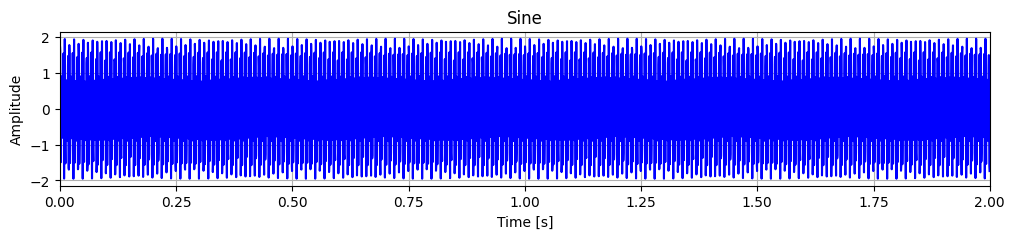

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


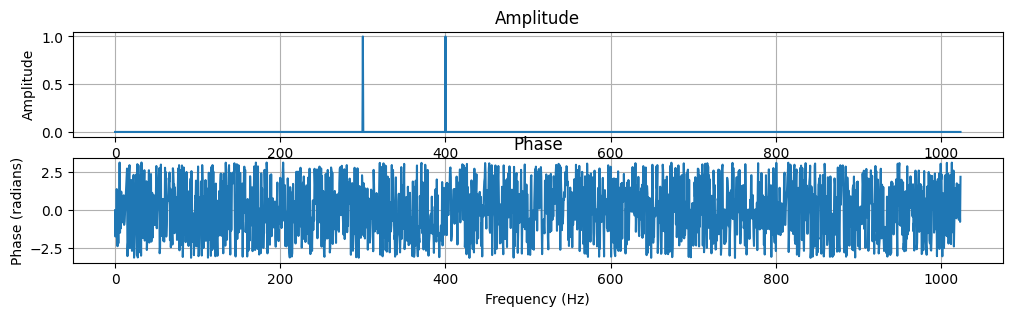

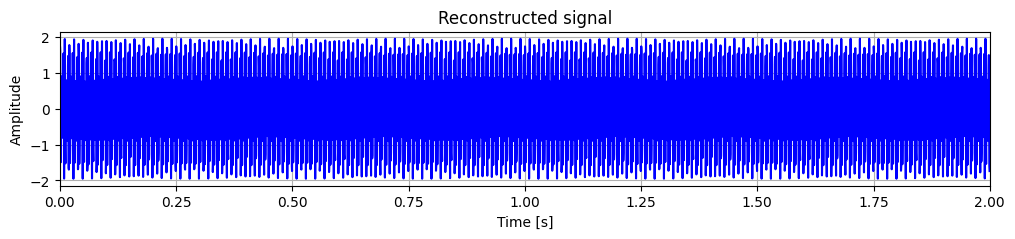

<Figure size 640x480 with 0 Axes>

In [41]:
Simple_DFT()

In [45]:
def FFT_IFFT():

  A = 1
  frequency = 60
  sample_rate = 2048
  duration = 2
  n = sample_rate * duration
  phi_0 = 0
  duty_cycle = 5
  T= 1.0/sample_rate

  sin1 = SinSignal(A * 3, frequency, n, phi_0)
  sin2 = SinSignal(A, frequency * 4, n, phi_0)
  sin3 = SinSignal(A / 2, frequency * 8, n, phi_0)

  signal = sin1.generate_sound() + sin2.generate_sound() + sin3.generate_sound()
  print(signal)

  plot_waveform(signal, 'Sine', 1, np.linspace(0, duration, int(n), endpoint=False))

  original_length = len(signal)
  FX = FFTZ(signal)
  # амплитудный спектр
  amplitude_spectrum = np.abs(FX)
  # фазовый спектр
  phase_spectrum = np.angle(FX)
  # вычисляет частоты, соответствующие каждому компоненту FFTZ
  freq_axis = np.fft.fftfreq(len(FX), 1 / sample_rate)
  plt.figure(figsize=(12, 3))
  plt.subplot(2, 1, 1)
  n_oneside = (len(FX))//2

  # оставляем только положительные частоты по оси иксов
  freq_axis = freq_axis[:n_oneside]
  amplitude_spectrum = amplitude_spectrum[:n_oneside]
  phase_spectrum = phase_spectrum[:n_oneside]
  plt.plot(freq_axis, amplitude_spectrum / (len(FX) // 2))
  plt.title('Amplitude')
  plt.xlim(0,len(freq_axis))
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.xlim(0, 1000)

  plt.grid()
  plt.subplot(2, 1, 2)
  plt.plot(freq_axis, phase_spectrum)
  plt.title('Phase')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Phase (radians)')
  plt.xlim(0, len(freq_axis))
  plt.xlim(0, 1000)

  plt.grid()
  rec_signal = IFFTN(FX)
  plot_waveform(rec_signal, "Reconstructed signal", 1,  np.linspace(0, len(rec_signal)//sample_rate, int(len(rec_signal)), endpoint=False))
  plt.tight_layout()
  plt.show()

[ 0.          1.71827098  2.172415   ... -1.89850641 -2.172415
 -1.71827098]


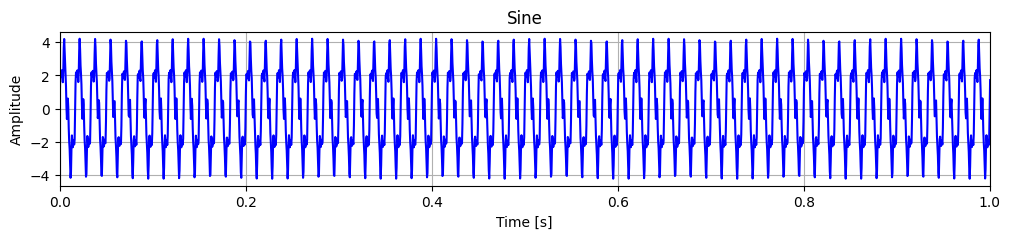

4096


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


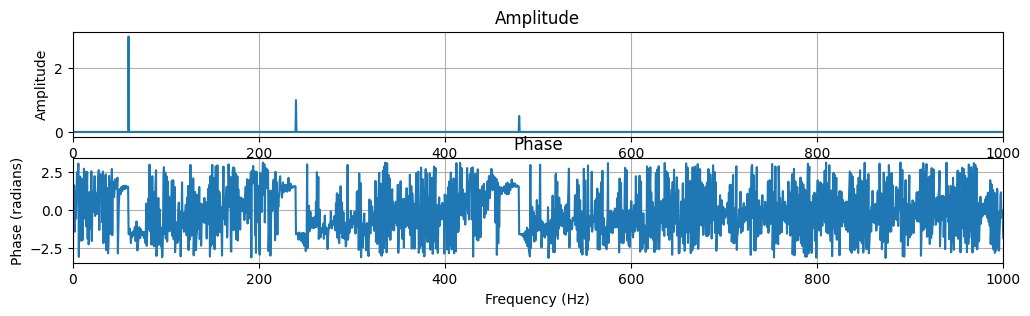

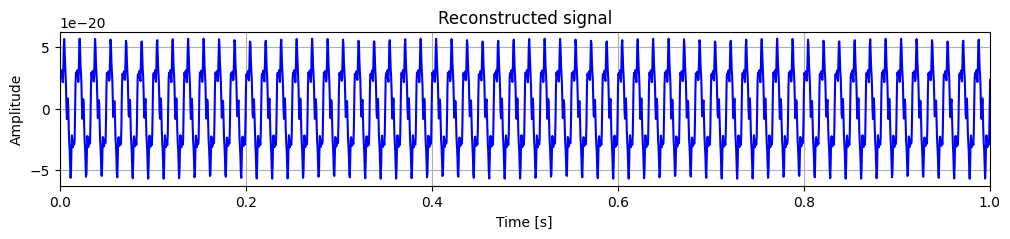

<Figure size 640x480 with 0 Axes>

In [46]:
FFT_IFFT()

In [107]:
def low_pass_filter(signal, cutoff_freq, sample_rate):
    DFT_values = FFTZ(signal)
    n = len(DFT_values)
    freqs = np.fft.fftfreq(n, 1 / sample_rate)
    filtered_DFT_values = np.array([DFT_values[k] if np.abs(freqs[k]) < cutoff_freq else 0 for k in range(n)])
    filtered_signal = IFFTN(filtered_DFT_values)
    return np.real(filtered_signal)

def high_pass_filter(signal, cutoff_freq, sample_rate):
    DFT_values = FFTZ(signal)
    n = len(DFT_values)
    freqs = np.fft.fftfreq(n, 1 / sample_rate)
    filtered_DFT_values = np.array([DFT_values[k] if np.abs(freqs[k]) > cutoff_freq else 0 for k in range(n)])
    filtered_signal = IFFTN(filtered_DFT_values)
    return np.real(filtered_signal)

def band_pass_filter(signal, low_cutoff_freq, high_cutoff_freq, sample_rate):
    low_filtered = low_pass_filter(signal, high_cutoff_freq, sample_rate)
    band_filtered = high_pass_filter(low_filtered, low_cutoff_freq, sample_rate)

    return band_filtered

In [108]:
def generate_random_signal(num_frequencies, freq_range,t):
    signal = np.zeros(t.shape)

    frequencies = np.random.uniform(freq_range[0], freq_range[1], num_frequencies)
    amplitudes = np.random.uniform(0.1, np.iinfo(np.int16).max, num_frequencies)

    for freq, amp in zip(frequencies, amplitudes):
        signal += amp * np.sin(2 * np.pi * freq * t)

    return signal, frequencies

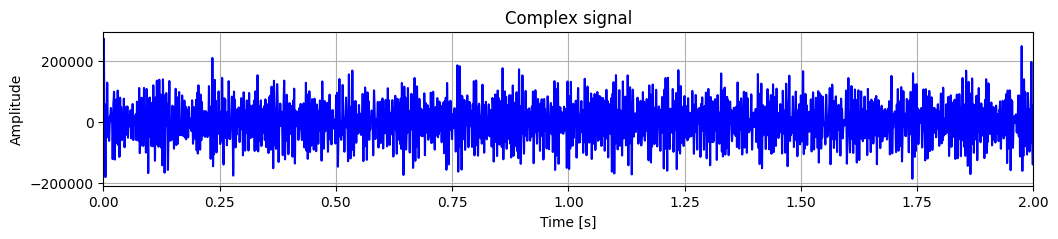

In [111]:
frequency = 440
sample_rate = 32768
duration = 2
n = sample_rate * duration
t = np.linspace(0, duration, int(n), endpoint=False)
signal, freq = generate_random_signal(20,[100, 440], t)
plot_waveform(signal, "Complex signal", 2,t)

wavfile.write("sin.wav", sample_rate, signal.astype("int16"))
display.Audio("sin.wav")

65536


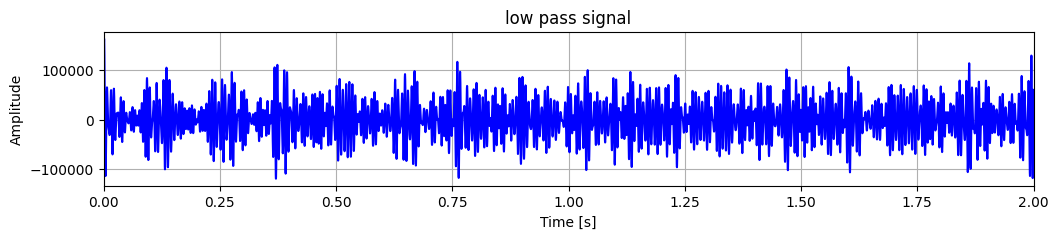

In [112]:
signal_with_low_pass = low_pass_filter(signal,200, sample_rate)

plot_waveform(signal_with_low_pass, "low pass signal", 2,t)

wavfile.write("sin_with_low_pass.wav", sample_rate, signal_with_low_pass.astype("int16"))
display.Audio("sin_with_low_pass.wav")

65536


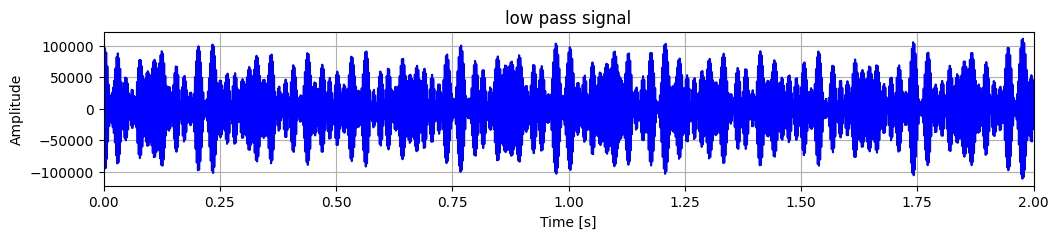

In [113]:
signal_with_high_pass = high_pass_filter(signal,300, sample_rate)

plot_waveform(signal_with_high_pass, "low pass signal", 2,t)

wavfile.write("signal_with_high_pass.wav", sample_rate, signal_with_high_pass.astype("int16"))
display.Audio("signal_with_high_pass.wav")

65536
65536


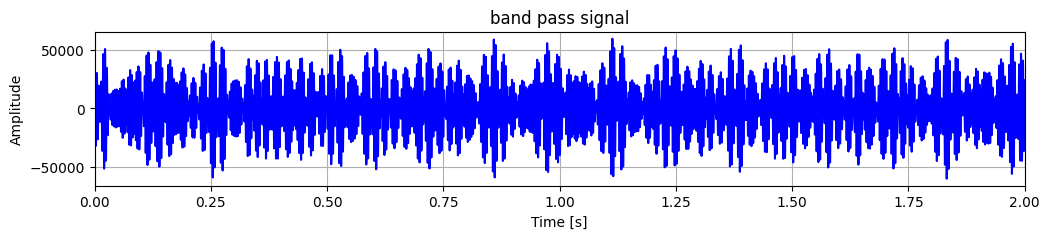

In [114]:
signal_with_band_pass = band_pass_filter(signal,200,300, sample_rate)

plot_waveform(signal_with_band_pass, "band pass signal", 2,t)

wavfile.write("signal_with_band_pass.wav", sample_rate, signal_with_band_pass.astype("int16"))
display.Audio("signal_with_band_pass.wav")